In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.transforms import Resize
from PIL import Image
from skimage.color import rgb2lab
import os
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import PIL, urllib
from torchvision import utils
from torch.utils.data import Subset
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 2, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, losses, train_acc, val_acc = [], [], [], []
    n = 0  # the number of iterations
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check if CUDA is available
    model.to(device)  # Move model to the GPU if available

    for epoch in range(num_epochs):
        for batch_idx, imgs in enumerate(train_loader):
            # Move tensors to GPU if available
            imgs_size = imgs.size()

            # Convert RGB images to LAB
            img_lab = rgb2lab(imgs.permute(0, 2, 3, 1).cpu())  # Convert images to LAB space
            L = torch.tensor(img_lab[:, :, :, 0], dtype=torch.float32).unsqueeze(1).to(device) # Extract L channel and move to GPU
            AB = torch.tensor(img_lab[:, :, :, 1:], dtype=torch.float32).to(device) / 128.0  # Extract AB channels and move to GPU, normalize
            AB_resized = AB.permute(0, 3, 1, 2)

            # Forward pass
            out = model(L)

            # Compute the total loss
            loss = criterion(out, AB_resized)

            # Backward pass (compute parameter updates)
            loss.backward()


            # Optimization step
            optimizer.step()

            # Clean up step for PyTorch
            optimizer.zero_grad()


        # Calculate training and validation accuracies after each epoch
        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)

        # Save metrics for plotting
        losses.append(loss.item())
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        epochs.append(epoch)

        print("Epoch #{}, Training Accuracy {:.7f}, Validation Accuracy {:.7f}, Loss {:.7f}".format(epoch, train_accuracy, val_accuracy, loss.item()))

    # Plotting
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch #")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [6]:
def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Set the model to evaluation mode
    for batch_idx, imgs in enumerate(dataloader):
        imgs = imgs.to(device)  # Move input tensor to the same device as the model

        # Convert RGB images to LAB
        img_lab = rgb2lab(imgs.permute(0, 2, 3, 1).cpu().numpy())
        L = torch.tensor(img_lab[:, :, :, 0], dtype=torch.float32).unsqueeze(1).to(device)
        AB = torch.tensor(img_lab[:, :, :, 1:], dtype=torch.float32).to(device) / 128.0
        AB_resized = AB.permute(0, 3, 1, 2)

        out = model(L)

        # Calculate accuracy
        predicted_AB = out.permute(0, 2, 3, 1).detach().cpu().numpy() * 128.0

        # Ensure dimensions match
        AB_np = AB.squeeze().cpu().numpy() * 128.0
        difference = np.abs(predicted_AB - AB_np)
        correct += np.sum(difference < 5)  # Consider a prediction correct if the difference is less than 5
        total += np.prod(AB_np.shape)
    accuracy = correct / total
    return accuracy


In [7]:
google_drive_path = '/content/drive/MyDrive/APS360_Project_Data/New_APS_360_Data/landscape Images/color'
from torch.utils.data import Subset
import torch
from torchvision.transforms import Resize
import torch.nn.functional as F
from skimage.color import rgb2lab
from torchvision import transforms

# Assuming Resize and ImageDataset are imported and defined correctly

# Example usage:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = CustomImageDataset(google_drive_path, transform=transform)
subset = Subset(dataset, range(5500))
subset_1 = Subset(dataset, range(5501, 6000))

train_loader = DataLoader(subset, batch_size=64, shuffle=True)
val_loader = DataLoader(subset_1, batch_size=64, shuffle=True)

CUDA is available!  Training on GPU ...
Epoch #0, Training Accuracy 0.4906403, Validation Accuracy 0.4794290, Loss 0.0120473
Epoch #1, Training Accuracy 0.4904067, Validation Accuracy 0.4771404, Loss 0.0095332
Epoch #2, Training Accuracy 0.4853183, Validation Accuracy 0.4699221, Loss 0.0082143
Epoch #3, Training Accuracy 0.4821069, Validation Accuracy 0.4673942, Loss 0.0083306
Epoch #4, Training Accuracy 0.5015171, Validation Accuracy 0.4842246, Loss 0.0088708
Epoch #5, Training Accuracy 0.5077340, Validation Accuracy 0.4926536, Loss 0.0112901
Epoch #6, Training Accuracy 0.5157149, Validation Accuracy 0.4997481, Loss 0.0094608
Epoch #7, Training Accuracy 0.5183463, Validation Accuracy 0.5001057, Loss 0.0087188
Epoch #8, Training Accuracy 0.5199666, Validation Accuracy 0.5036139, Loss 0.0103820
Epoch #9, Training Accuracy 0.5174434, Validation Accuracy 0.5008069, Loss 0.0078386
Epoch #10, Training Accuracy 0.5165668, Validation Accuracy 0.4982888, Loss 0.0071668
Epoch #11, Training Accu

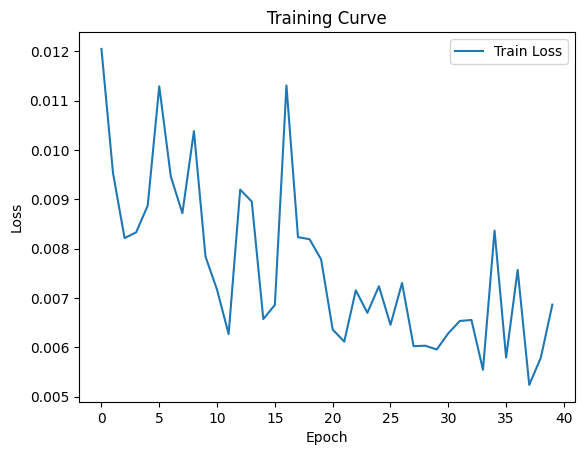

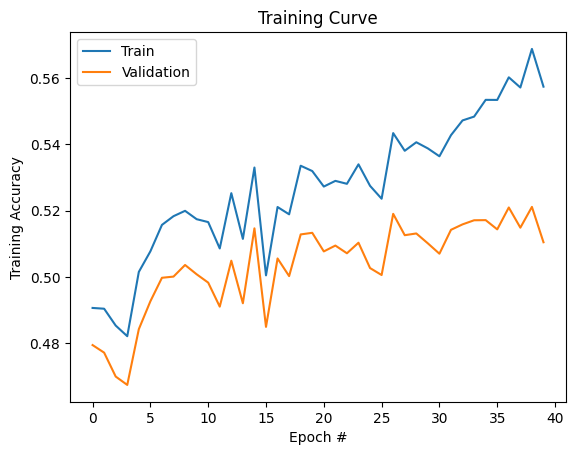

Final Training Accuracy: 0.5574603548916903
Final Validation Accuracy: 0.5104773603603692


In [8]:
model = ColorizationModel()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Train the model
train(model, train_loader, val_loader, num_epochs=40, learning_rate=0.0001)

# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/APS360_Project_Data/colorization_model_7.pth')

<ipython-input-16-5000a9e7dab3>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  AB = torch.tensor(AB, dtype=torch.float32)*128


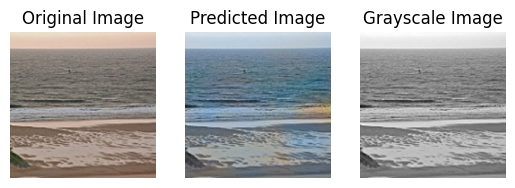

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from skimage.color import lab2rgb

model = ColorizationModel()

# Specify the path to the saved model
saved_model_path = '/content/drive/MyDrive/APS360_Project_Data/colorization_model_7.pth'

# Load the saved model
model.load_state_dict(torch.load(saved_model_path))

# Set the model to evaluation mode
model.eval()

test_dataset = Subset(dataset, range(6001, 7000))

image_number = 32
# Original Image

original_img = test_dataset[image_number].permute(1, 2, 0).numpy()
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# Predicted Image
img = test_dataset[image_number].unsqueeze(0)
imgs = img.permute(0, 2, 3, 1)  # Permute dimensions
imgs_np = imgs.numpy()
img_lab = rgb2lab(imgs_np)
L = img_lab[:, :, :, 0]

L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
AB = model(L)
AB = torch.tensor(AB, dtype=torch.float32)*128
AB = AB.permute(0, 1, 2, 3)

# Combine L and AB channels
predicted_lab = torch.cat((L, AB), dim=1)

# Convert LAB image to RGB
predicted_rgb = lab2rgb(predicted_lab.squeeze().permute(1, 2, 0).detach().numpy())

# Plot Predicted Image
plt.subplot(1, 3, 2)
plt.imshow(predicted_rgb)
plt.title('Predicted Image')
plt.axis('off')

# Plot Grayscale Image
plt.subplot(1, 3, 3)
plt.imshow(L.squeeze().detach().numpy(), cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()
